# Lesson 4: Tool Use and Conversational Chess

## Setup

In [1]:
from pathlib import Path

import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY1"]=os.getenv("GROQ_API_KEY1")


config_list = [
    {
        # Let's choose the Mixtral 8x22B model
        #"model": "llama3-8b-8192",
        "model": "llama-3.3-70b-versatile",
        #"model": "deepseek-r1-distill-llama-70b",
        # Provide your Mistral AI API key here or put it into the MISTRAL_API_KEY environment variable.
        "api_key": os.environ.get("GROQ_API_KEY1"),
        # We specify the API Type as 'mistral' so it uses the Mistral AI client class
        "api_type": "groq",
    }
]

llm_config={"config_list": config_list}
print(llm_config)

{'config_list': [{'model': 'llama-3.3-70b-versatile', 'api_key': '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', 'api_type': 'groq'}]}


In [2]:
#!pip install chess

  Preparing metadata (setup.py) ... done
  Created wheel for chess: filename=chess-1.11.1-py3-none-any.whl size=148497 sha256=c0369a6e26c416fd695186ae4690d5475871ec753e2b16b72f2cf1cf26a24e11
  Stored in directory: /Users/sunjsg/Library/Caches/pip/wheels/2e/2d/23/1bfc95db984ed3ecbf6764167dc7526d0ab521cf9a9852544e
Successfully built chess


In [3]:
import chess
import chess.svg
from typing_extensions import Annotated

## Initialize the chess board

In [4]:
board = chess.Board()

In [5]:
made_move = False

## Define the needed tools

### 1. Tool for getting legal moves

In [6]:
def get_legal_moves(
    
) -> Annotated[str, "A list of legal moves in UCI format"]:
    return "Possible moves are: " + ",".join(
        [str(move) for move in board.legal_moves]
    )

### 2. Tool for making a move on the board

In [7]:
def make_move(
    move: Annotated[str, "A move in UCI format."]
) -> Annotated[str, "Result of the move."]:
    move = chess.Move.from_uci(move)
    board.push_uci(str(move))
    global made_move
    made_move = True
    
    # Display the board.
    display(
        chess.svg.board(
            board,
            arrows=[(move.from_square, move.to_square)],
            fill={move.from_square: "gray"},
            size=200
        )
    )
    
    # Get the piece name.
    piece = board.piece_at(move.to_square)
    piece_symbol = piece.unicode_symbol()
    piece_name = (
        chess.piece_name(piece.piece_type).capitalize()
        if piece_symbol.isupper()
        else chess.piece_name(piece.piece_type)
    )
    return f"Moved {piece_name} ({piece_symbol}) from "\
    f"{chess.SQUARE_NAMES[move.from_square]} to "\
    f"{chess.SQUARE_NAMES[move.to_square]}."

## Create agents

You will create the player agents and a board proxy agents for the chess board.

In [8]:
from autogen import ConversableAgent

/Users/sunjsg/anaconda3/envs/env310finrobot/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-31 05:25:50,415	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
/Users/sunjsg/anaconda3/envs/env310finrobot/lib/python3.10/site-packages/flaml/__init__.py:20: UserWarning: flaml.automl is not available. Please install flaml[automl] to enable AutoML functionalities.
  warnings.warn("flaml.automl is not available. Please install flaml[automl] to enable AutoML functionalities.")


In [9]:
# Player white agent
player_white = ConversableAgent(
    name="Player White",
    system_message="You are a chess player and you play as white. "
    "First call get_legal_moves(), to get a list of legal moves. "
    "Then call make_move(move) to make a move.",
    llm_config=llm_config,
)

In [10]:
# Player black agent
player_black = ConversableAgent(
    name="Player Black",
    system_message="You are a chess player and you play as black. "
    "First call get_legal_moves(), to get a list of legal moves. "
    "Then call make_move(move) to make a move.",
    llm_config=llm_config,
)

In [11]:
def check_made_move(msg):
    global made_move
    if made_move:
        made_move = False
        return True
    else:
        return False


In [12]:
board_proxy = ConversableAgent(
    name="Board Proxy",
    llm_config=False,
    is_termination_msg=check_made_move,
    default_auto_reply="Please make a move.",
    human_input_mode="NEVER",
)

## Register the tools

A tool must be registered for the agent that calls the tool and the agent that executes the tool.

In [13]:
from autogen import register_function

In [14]:
for caller in [player_white, player_black]:
    register_function(
        get_legal_moves,
        caller=caller,
        executor=board_proxy,
        name="get_legal_moves",
        description="Get legal moves.",
    )
    
    register_function(
        make_move,
        caller=caller,
        executor=board_proxy,
        name="make_move",
        description="Call this tool to make a move.",
    )

/Users/sunjsg/anaconda3/envs/env310finrobot/lib/python3.10/site-packages/autogen/agentchat/conversable_agent.py:2531: UserWarning: Function 'get_legal_moves' is being overridden.
  warnings.warn(f"Function '{name}' is being overridden.", UserWarning)
/Users/sunjsg/anaconda3/envs/env310finrobot/lib/python3.10/site-packages/autogen/agentchat/conversable_agent.py:2531: UserWarning: Function 'make_move' is being overridden.
  warnings.warn(f"Function '{name}' is being overridden.", UserWarning)


In [15]:
player_black.llm_config["tools"]

[{'type': 'function',
  'function': {'description': 'Get legal moves.',
   'name': 'get_legal_moves',
   'parameters': {'type': 'object', 'properties': {}, 'required': []}}},
 {'type': 'function',
  'function': {'description': 'Call this tool to make a move.',
   'name': 'make_move',
   'parameters': {'type': 'object',
    'properties': {'move': {'type': 'string',
      'description': 'A move in UCI format.'}},
    'required': ['move']}}}]

## Register the nested chats

Each player agent will have a nested chat with the board proxy agent to
make moves on the chess board.

In [16]:
player_white.register_nested_chats(
    trigger=player_black,
    chat_queue=[
        {
            "sender": board_proxy,
            "recipient": player_white,
            "summary_method": "last_msg",
        }
    ],
)

player_black.register_nested_chats(
    trigger=player_white,
    chat_queue=[
        {
            "sender": board_proxy,
            "recipient": player_black,
            "summary_method": "last_msg",
        }
    ],
)

## Start the Game

The game will start with the first message.

<p style="background-color:#ECECEC; padding:15px; "> <b>Note:</b> In this lesson, you will use GPT 4 for better results. Please note that the lesson has a quota limit. If you want to explore the code in this lesson further, we recommend trying it locally with your own API key.

**Note**: You might get a slightly different moves than what's shown in the video.

In [17]:
board = chess.Board()

chat_result = player_black.initiate_chat(
    player_white,
    message="Let's play chess! Your move.",
    max_turns=2,
)

Player Black (to Player White):

Let's play chess! Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

Let's play chess! Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

***** Suggested tool call (call_sazc): get_legal_moves *****
Arguments: 
{}
************************************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION get_legal_moves...
Call ID: call_sazc
Input arguments: {}
Board Proxy (to Player White):

***** Response from calling tool (call_sazc) *****
Possible moves are: g1h3,g1f3,b1c3,b1a3,h2h3

/Users/sunjsg/anaconda3/envs/env310finrobot/lib/python3.10/site-packages/autogen/oai/groq.py:282: UserWarning: Cost calculation not available for model llama-3.3-70b-versatile
  warnings.warn(f"Cost calculation not available for model {model}", UserWarning)


Player White (to Board Proxy):

<function=make_move {"move": "e2e4"}</function>

--------------------------------------------------------------------------------
Board Proxy (to Player White):

Please make a move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

<function=make_move {"move": "e2e4"}</function>

--------------------------------------------------------------------------------
Board Proxy (to Player White):

Please make a move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

***** Suggested tool call (call_bn4b): get_legal_moves *****
Arguments: 
{}
************************************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION get_legal_moves...
Call ID: call_bn4b
Input arguments: {}
Board Prox

KeyboardInterrupt: 

## Adding a fun chitchat to the game!

In [17]:
player_white = ConversableAgent(
    name="Player White",
    system_message="You are a chess player and you play as white. "
    "First call get_legal_moves(), to get a list of legal moves. "
    "Then call make_move(move) to make a move. "
    "After a move is made, chitchat to make the game fun.",
    llm_config=llm_config,
)

In [18]:
player_black = ConversableAgent(
    name="Player Black",
    system_message="You are a chess player and you play as black. "
    "First call get_legal_moves(), to get a list of legal moves. "
    "Then call make_move(move) to make a move. "
    "After a move is made, chitchat to make the game fun.",
    llm_config=llm_config,
)

In [19]:
for caller in [player_white, player_black]:
    register_function(
        get_legal_moves,
        caller=caller,
        executor=board_proxy,
        name="get_legal_moves",
        description="Get legal moves.",
    )

    register_function(
        make_move,
        caller=caller,
        executor=board_proxy,
        name="make_move",
        description="Call this tool to make a move.",
    )

player_white.register_nested_chats(
    trigger=player_black,
    chat_queue=[
        {
            "sender": board_proxy,
            "recipient": player_white,
            "summary_method": "last_msg",
            "silent": True,
        }
    ],
)

player_black.register_nested_chats(
    trigger=player_white,
    chat_queue=[
        {
            "sender": board_proxy,
            "recipient": player_black,
            "summary_method": "last_msg",
            "silent": True,
        }
    ],
)

Player Black (to Player White):

Let's play chess! Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...


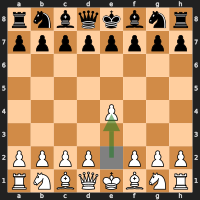


>>>>>>>> USING AUTO REPLY...
Player White (to Player Black):

Great, the pawn has moved from e2 to e4. Your move!

While you think about your move, tell me, do you have any favorite chess openings or players that inspire you?

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...


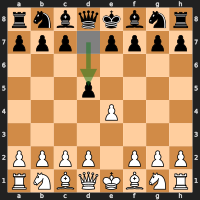


>>>>>>>> USING AUTO REPLY...
Player Black (to Player White):

I've moved my pawn from d7 to d5, challenging your central control!

Chess can be quite the mental workout, right? While we wait, what's the most memorable game of chess you've ever played or watched?

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...


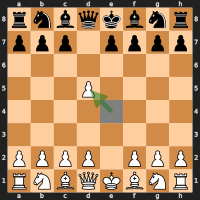


>>>>>>>> USING AUTO REPLY...
Player White (to Player Black):

I've captured your pawn on d5. The board is heating up!

Now it's your move. How are you planning to respond to this developing situation?

--------------------------------------------------------------------------------


In [20]:
board = chess.Board()

chat_result = player_black.initiate_chat(
    player_white,
    message="Let's play chess! Your move.",
    max_turns=2,
)

**Note:** 
To add human input to this game, add **human_input_mode="ALWAYS"** for both player agents.